In [82]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd

import topf

cmap = "hsv"

In [83]:
def loop(n_loops, radius, n_samples, noise, reflect = False):
    t = np.linspace(0,2*np.pi,2*n_loops +1)
    x = radius*np.cos(t)
    y = radius*np.sin(t)
    rad = radius*np.pi/n_loops
    data = noisy_circle(n_samples, noise, x[0], y[0], rad)
    for j in range(2,len(t)-4,2):
        data = np.concatenate([data, noisy_circle(n_samples, noise, x[j], y[j], rad)])
    if reflect:
        data = np.array([[-el[0], -el[1]] for el in data])
    return data    

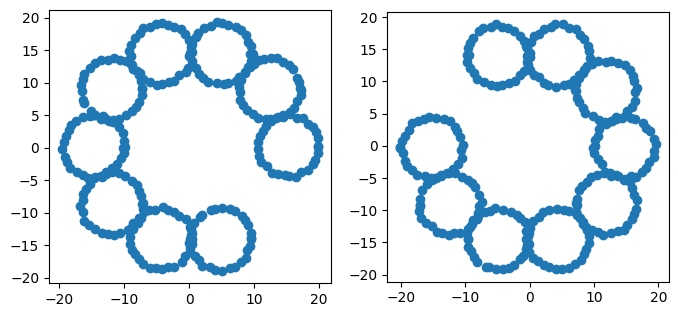

In [84]:
plt.subplot(1, 2, 1)
A = loop(10, 15, 30, 0.1)
plt.scatter(A[:,0],A[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(1, 2, 2)
B = loop(10, 15, 30, 0.1, True)
plt.scatter(B[:,0],B[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [85]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic 
H_all = [PH(x) for x in tqdm([A,B])]
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.99s/it]


In [86]:
# import topf
# topf_all = [topf.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 10]) for x in tqdm([A, B])]
# y0 = topf_all[0][0]
# y1 = topf_all[1][0]
# df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
# p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

In [87]:
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [88]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

In [89]:
# # similarity with kernel
# h = 0.25
# K0 = topo_util.get_kernel(A, h)
# L0 = topo_util.symmetric_laplacian(K0)
# K0 /= K0.sum(-1).reshape(-1, 1)
# K1 = topo_util.get_kernel(B, h)
# L1 = topo_util.symmetric_laplacian(K1)
# K1 /= K1.sum(-1).reshape(-1, 1)
# 
# y0_imputed = topo_util.impute_laplacian(y0, L0)
# y1_imputed = topo_util.impute_laplacian(y1, L1)
# 
# y0 = y0_imputed; y1 = y1_imputed;

In [90]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "euclidean"); C_v0 /= np.mean(C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "euclidean"); C_v1 /= np.mean(C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt)

In [91]:
alpha = 0.5
beta = 5
v0 = p
v1 = q
w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = beta, print_iter = 5, iter = 50, 
                          eps_s = 0.003, eps_f = 0.01,
                          solver = "sinkhorn")

Iteration 0,	 obj = 0.3381524298600474,	 obj_terms = {'coot': 0.23148522672112515, 'ot': 0.004739543396011429, 'gw': 0.10192765974291082}
Iteration 5,	 obj = 0.22975131218032444,	 obj_terms = {'coot': 0.16891098187229625, 'ot': 0.004327554594129736, 'gw': 0.05651277571389845}
Iteration 10,	 obj = 0.19725890029884927,	 obj_terms = {'coot': 0.16644351247110456, 'ot': 0.003086792107519421, 'gw': 0.027728595720225273}
Iteration 15,	 obj = 0.22979278969294406,	 obj_terms = {'coot': 0.16897504955359416, 'ot': 0.004327554594129736, 'gw': 0.05649018554522016}
Iteration 20,	 obj = 0.19725897883611254,	 obj_terms = {'coot': 0.16644351213440228, 'ot': 0.003086792107519421, 'gw': 0.02772867459419085}
Iteration 25,	 obj = 0.2297927898556905,	 obj_terms = {'coot': 0.16897504980761902, 'ot': 0.004327554594129736, 'gw': 0.056490185453941744}
Iteration 30,	 obj = 0.1972589788364297,	 obj_terms = {'coot': 0.16644351213440084, 'ot': 0.003086792107519421, 'gw': 0.027728674594509437}
Iteration 35,	 obj = 0

In [92]:
sizes_p = 40 + np.zeros((len(p_spt)))
sizes_q = 40 + np.zeros((len(q_spt)))
sizes_p[-1] = 100
sizes_q[-1] = 100

color_p = 1+ np.zeros((len(p_spt)))
color_q =  1+np.ones((len(q_spt)))
# plt.figure(figsize = (5, 5))
# pd.plot_pd(p, q, p_spt, q_spt, pi, color_p, color_q, sizes_p, sizes_q)
# plt.savefig('outputs/ex3_diagrams.png', dpi=300)

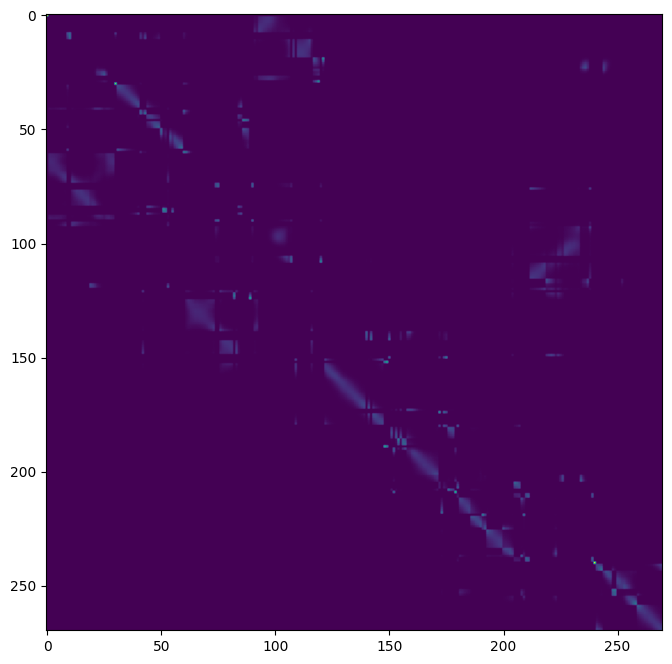

In [93]:
plt.imshow(pi_s)

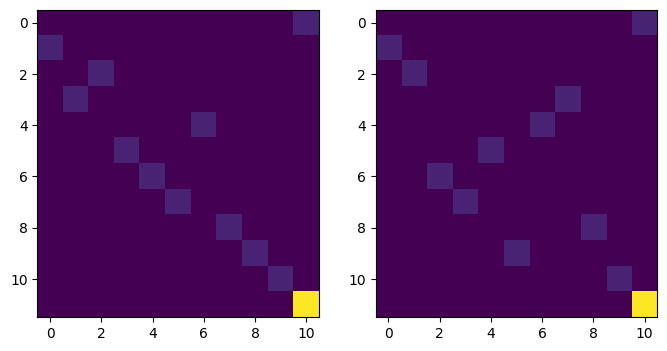

In [94]:
plt.subplot(1, 2, 1)
plt.imshow(pi)
plt.subplot(1, 2, 2)
plt.imshow(pi_f)

Text(0.5, 1.0, 'Geometric cycle matching')

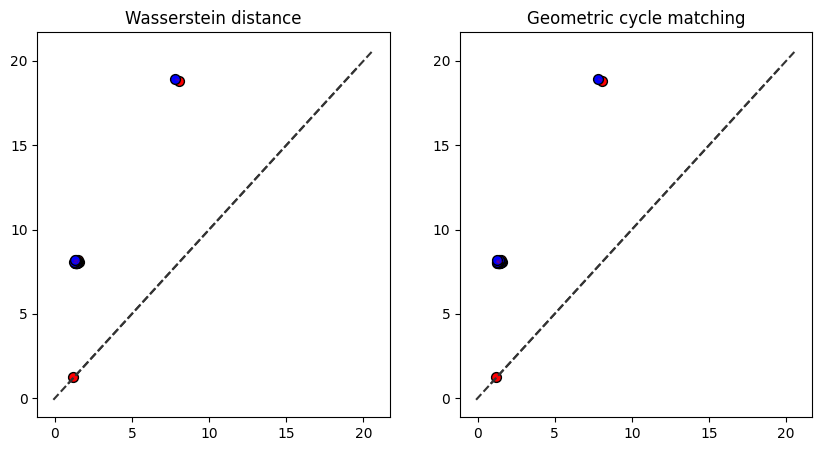

In [95]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
pd.plot_pd(p_spt, color = 'red'); pd.plot_pd(q_spt, color = 'blue')
pd.plot_pd_connections(p, q, p_spt, q_spt, pi)
plt.title("Wasserstein distance")
plt.subplot(1, 2, 2)
pd.plot_pd(p_spt, color = 'red'); pd.plot_pd(q_spt, color = 'blue')
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.title("Geometric cycle matching")
# plt.savefig('filename.png', dpi=300)

In [96]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0

/tmp/ipykernel_2105596/3284110093.py:2: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_2105596/3284110093.py:3: RuntimeWarning:

invalid value encountered in divide



In [97]:
colour_source = list(np.zeros((len(A),)))
colour_pd = list(np.zeros((len(A),)))
colour_tpot = list(np.zeros((len(A),)))
for l in range(2,11):
    index_source = np.where((y0[:, -l] >0.7 ))[0]
    for el in index_source:
        colour_source[el] =  l-1
    index_pd = np.where((Q_pd[-l, :].reshape(1, -1) * y1).sum(-1) >0.7 )[0]
    for el in index_pd:
        colour_pd[el] = l-1
    index_tpot = np.where((Q[-l, :].reshape(1, -1) * y1).sum(-1) >0.7 )[0]
    for el in index_tpot:
        colour_tpot[el] = l-1

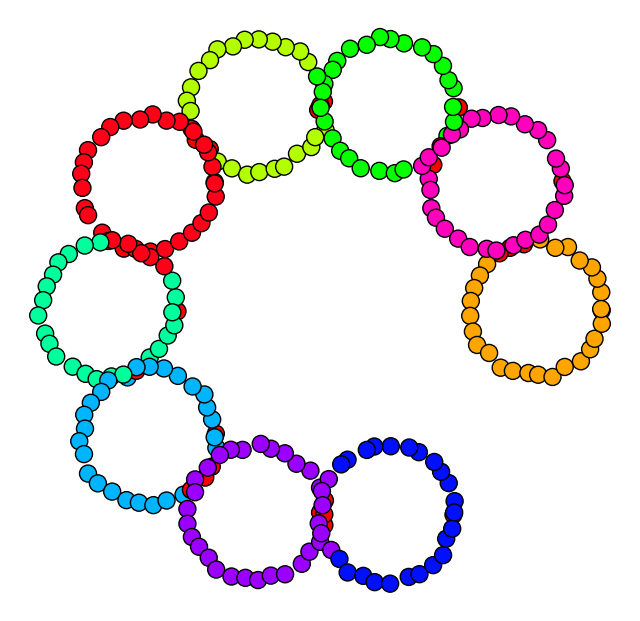

In [98]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1], c = colour_source, s=150, edgecolors='black', vmax=9, vmin=0, cmap = cmap)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/source_ex3.svg', dpi=300)
plt.show()

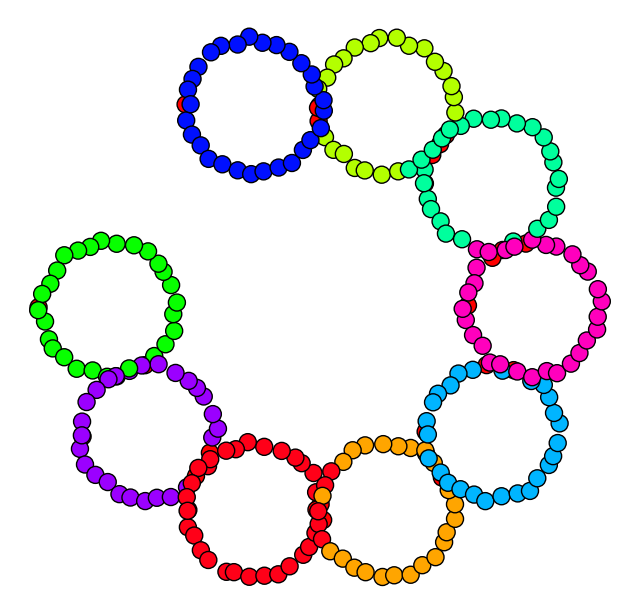

In [99]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_pd, s=150,edgecolors='black', vmax=9, vmin=0, cmap = cmap)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/targetpd_ex3.svg')
plt.show()

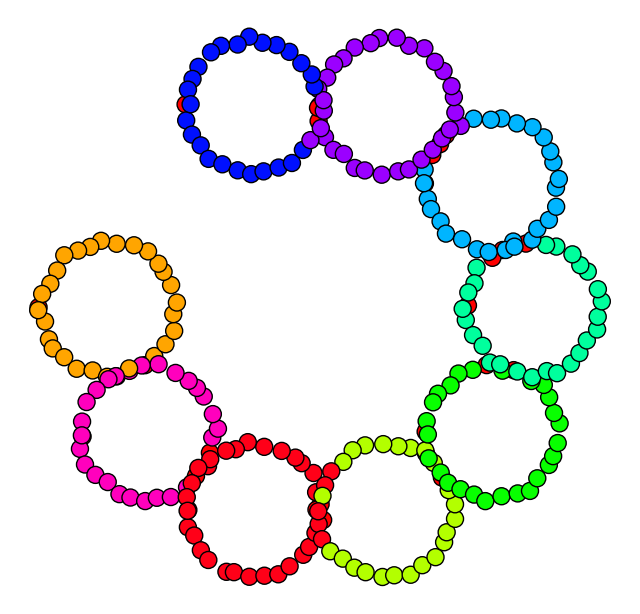

In [100]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_tpot, s=150,edgecolors='black', vmax=9, vmin=0, cmap = cmap)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/targettpot_ex3_alpha{}_beta{}.svg'.format(alpha,beta))
plt.show()